In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import xgboost
from xgboost import XGBRegressor, DMatrix

In [2]:
eu = pd.read_csv('eu.csv', index_col=0, parse_dates=True, skipinitialspace=True)
eu.drop('date', axis='columns', inplace=True)
eu.head(5)

,open,high,low,close,volume
1971-01-04,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,0.5366,0.5366,0.5366,0.5366,1
1971-01-06,0.5365,0.5365,0.5365,0.5365,1
1971-01-07,0.5368,0.5368,0.5368,0.5368,1
1971-01-08,0.5371,0.5371,0.5371,0.5371,1


In [3]:
eu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12115 entries, 1971-01-04 to 2019-05-09
Data columns (total 5 columns):
open      12115 non-null float64
high      12115 non-null float64
low       12115 non-null float64
close     12115 non-null float64
volume    12115 non-null int64
dtypes: float64(4), int64(1)
memory usage: 567.9 KB


In [4]:
eu.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [5]:
eu.describe()

,open,high,low,close,volume
count,12115.000000,12115.000000,12115.000000,12115.000000,12115.000000
mean,1.072829,1.076753,1.068981,1.072871,20323.133884
std,0.234412,0.236481,0.232351,0.234409,37538.102171
min,0.536500,0.536500,0.536500,0.536500,1.000000
25%,0.878950,0.881650,0.875400,0.878700,231.000000
50%,1.110700,1.115000,1.107070,1.111100,1891.000000
75%,1.257600,1.263790,1.251900,1.257600,11863.000000
max,1.599500,1.603800,1.586600,1.599700,308716.000000


In [6]:
eu.tail()

,open,high,low,close,volume
2019-05-01,1.12148,1.12644,1.11867,1.11941,52561
2019-05-02,1.11942,1.12187,1.11703,1.11709,59203
2019-05-03,1.11710,1.13236,1.11346,1.13234,62828
2019-05-08,1.11922,1.11927,1.11892,1.11920,698
2019-05-09,1.11902,1.11985,1.11860,1.11903,12844


In [7]:
eu.head()

,open,high,low,close,volume
1971-01-04,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,0.5366,0.5366,0.5366,0.5366,1
1971-01-06,0.5365,0.5365,0.5365,0.5365,1
1971-01-07,0.5368,0.5368,0.5368,0.5368,1
1971-01-08,0.5371,0.5371,0.5371,0.5371,1


C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


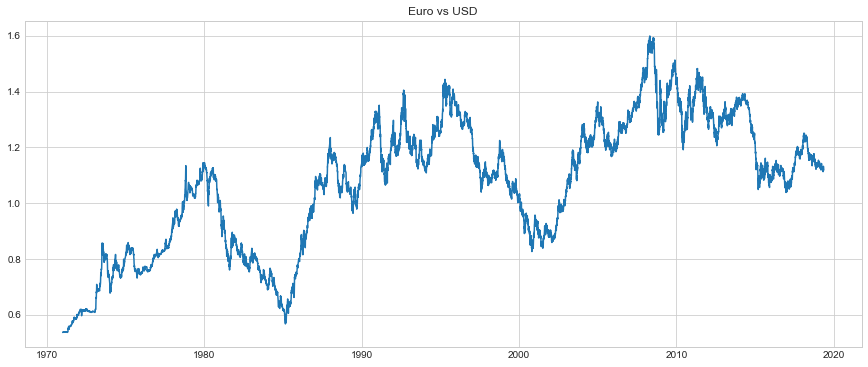

In [8]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('Euro vs USD')
plt.legend()
plt.show()

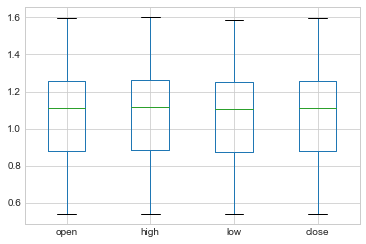

In [14]:
eu.drop('volume', axis=1).boxplot()

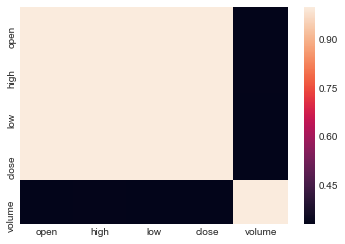

In [22]:
sns.heatmap(eu.corr())

In [15]:
#removing outliers above
vol_cut_off = eu.volume.std()*3 + eu.volume.mean()
eu.volume[eu.volume > vol_cut_off] = vol_cut_off

#removing outliers below
vol_cut_off = eu.volume.mean() - eu.volume.std()*3
eu.volume[eu.volume < vol_cut_off] = vol_cut_off

C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


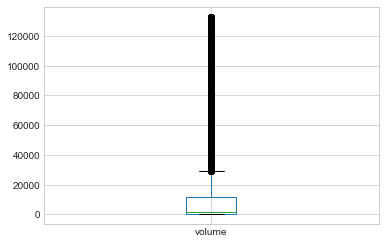

In [16]:
eu[['volume']].boxplot()

In [41]:
def generate_features(df):
    
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']                                            
        
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']                                       
    
     # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

In [42]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_price_5_365,std_volume_5,std_volume_30,std_volume_90,return_1,return_5,return_30,moving_avg_5,moving_avg_30,close
1972-01-28,0.6090,0.6091,0.6091,0.6091,0.6091,1.0,0.60896,0.604390,0.594187,0.563797,...,0.037210,0.0,0.0,0.0,0.000000,0.002964,0.020781,0.000593,0.000983,0.6090
1972-01-31,0.6092,0.6090,0.6090,0.6090,0.6090,1.0,0.60926,0.604957,0.594490,0.564083,...,0.013742,0.0,0.0,0.0,-0.000164,0.002469,0.019930,0.000494,0.000944,0.6092
1972-02-01,0.6107,0.6092,0.6092,0.6092,0.6092,1.0,0.60924,0.605367,0.594822,0.564371,...,0.013680,0.0,0.0,0.0,0.000328,-0.000164,0.014319,-0.000033,0.000680,0.6107
1972-02-02,0.6143,0.6107,0.6107,0.6107,0.6107,1.0,0.60942,0.605986,0.595189,0.564665,...,0.030499,0.0,0.0,0.0,0.002462,0.001476,0.021750,0.000296,0.001027,0.6143
1972-02-03,0.6127,0.6143,0.6143,0.6143,0.6143,1.0,0.61046,0.606776,0.595640,0.564973,...,0.095161,0.0,0.0,0.0,0.005895,0.008537,0.027773,0.001704,0.001308,0.6127


In [21]:
data.tail()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
2019-05-01,1.12148,1.11841,1.12140,1.12286,1.11753,55570.0,1.116498,1.123167,1.128969,1.147996,...,0.519469,0.002575,-0.001087,0.000205,-0.020278,-0.053679,-0.000211,-0.000320,-0.000210,1.11941
2019-05-02,1.11942,1.12148,1.11941,1.12644,1.11867,52561.0,1.117332,1.123123,1.128558,1.147710,...,0.518858,-0.001775,0.003739,-0.000821,-0.022597,-0.060496,0.000749,-0.000358,-0.000239,1.11709
2019-05-03,1.11710,1.11942,1.11709,1.12187,1.11703,59203.0,1.118124,1.122836,1.128139,1.147404,...,0.518669,-0.002073,0.003558,-0.005369,-0.023096,-0.064547,0.000713,-0.000366,-0.000256,1.13234
2019-05-08,1.11922,1.11710,1.13234,1.13236,1.11346,62828.0,1.121752,1.123332,1.128010,1.147165,...,0.519012,0.013652,0.016281,0.009297,-0.007094,-0.050544,0.003251,-0.000107,-0.000197,1.11920
2019-05-09,1.11902,1.11922,1.11920,1.11927,1.11892,698.0,1.121888,1.123222,1.127743,1.146909,...,0.590457,-0.011604,0.000608,-0.002069,-0.014849,-0.054522,0.000155,-0.000230,-0.000213,1.11903


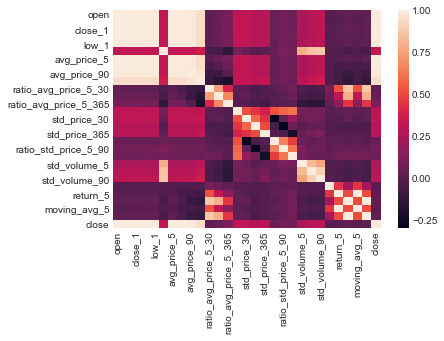

In [43]:
sns.heatmap(data.corr())

In [55]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(1980, 1, 1,0,0)
end_train = datetime.datetime(2015, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()


,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_price_5_365,std_volume_5,std_volume_30,std_volume_90,return_1,return_5,return_30,moving_avg_5,moving_avg_30,close
count,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,...,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000,9087.000000
mean,1.133141,1.133144,1.133190,1.137881,1.128461,16782.430505,1.133196,1.133222,1.133254,1.132794,...,0.139448,2362.345018,3206.169971,3896.044974,0.000019,0.000102,0.000467,0.000020,0.000020,1.133186
std,0.211646,0.211646,0.211625,0.213301,0.209965,29800.153537,0.211514,0.211128,0.210029,0.204825,...,0.085248,5178.726131,6426.142934,7268.085389,0.006722,0.015177,0.032277,0.003034,0.001535,0.211625
min,0.567200,0.567200,0.567200,0.568600,0.563300,1.000000,0.574540,0.580143,0.601424,0.637096,...,0.007469,10.305338,20.837238,35.377476,-0.042304,-0.067511,-0.147266,-0.013855,-0.007495,0.567200
25%,1.005100,1.005100,1.005050,1.009200,1.000850,791.000000,1.004900,1.005493,1.011185,1.015255,...,0.080454,318.457202,440.491329,534.112646,-0.003759,-0.009391,-0.020304,-0.001874,-0.000955,1.005050
50%,1.160300,1.160300,1.160100,1.165800,1.155500,3231.000000,1.160720,1.160781,1.161587,1.169078,...,0.119871,553.823076,665.458331,765.398637,-0.000088,-0.000100,-0.000759,-0.000005,-0.000019,1.160100
75%,1.296050,1.296050,1.296050,1.302600,1.290600,11206.500000,1.296431,1.297189,1.301977,1.292945,...,0.177461,1438.611904,1810.966656,1843.709067,0.003717,0.009407,0.020577,0.001888,0.000990,1.296050
max,1.599500,1.599500,1.599700,1.603800,1.586600,261024.000000,1.591080,1.579900,1.564808,1.506541,...,0.978365,75190.902404,62454.013043,46584.955565,0.052865,0.106059,0.141554,0.020409,0.006412,1.599700


In [56]:
#segregate data for validation
start_test = datetime.datetime(2016, 1, 1, 0, 0)
end_test = datetime.datetime(2019, 6, 7, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_price_5_365,std_volume_5,std_volume_30,std_volume_90,return_1,return_5,return_30,moving_avg_5,moving_avg_30,close
count,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,...,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,8.680000e+02,868.000000,868.000000
mean,1.138181,1.138151,1.138249,1.142530,1.134282,107647.589862,1.138182,1.137916,1.136860,1.133256,...,0.163363,16343.350073,20782.767354,25701.097266,0.000038,0.000196,0.000901,4.025136e-05,0.000046,1.138288
std,0.047470,0.047490,0.047482,0.047495,0.047471,39996.063858,0.047298,0.046829,0.045939,0.037078,...,0.101149,10626.912079,9920.634820,11156.254743,0.004690,0.009941,0.018160,1.987375e-03,0.000863,0.047453
min,1.038460,1.038460,1.038670,1.041750,1.032490,698.000000,1.041264,1.047622,1.058697,1.088630,...,0.021620,1020.633284,8222.703661,11320.362606,-0.025301,-0.027590,-0.046899,-5.571017e-03,-0.002279,1.038670
25%,1.110430,1.110228,1.110495,1.115290,1.106528,77694.250000,1.110311,1.107583,1.102537,1.104266,...,0.095515,9613.925198,13690.970507,17173.026326,-0.002877,-0.006630,-0.011021,-1.324364e-03,-0.000516,1.110560
50%,1.134495,1.134495,1.134410,1.138710,1.131220,104523.500000,1.134803,1.134616,1.132960,1.110948,...,0.137728,13748.675847,17255.514039,23463.237420,0.000086,-0.000033,-0.000405,-1.831058e-08,0.000002,1.134410
75%,1.170970,1.170970,1.171065,1.175175,1.166253,130086.500000,1.170009,1.168823,1.172845,1.172596,...,0.198481,19991.873917,24006.043296,31821.253028,0.002919,0.006623,0.012208,1.330600e-03,0.000591,1.171065
max,1.250730,1.250730,1.250780,1.255540,1.244800,308716.000000,1.243208,1.237799,1.234132,1.195315,...,0.714472,78028.379023,56134.172324,62581.437179,0.019299,0.034467,0.047592,6.825425e-03,0.002230,1.250780


In [57]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9087, 28), (868, 28), (9087,), (868,))

In [58]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [59]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.005
MAE: 0.004
R^2: 0.988


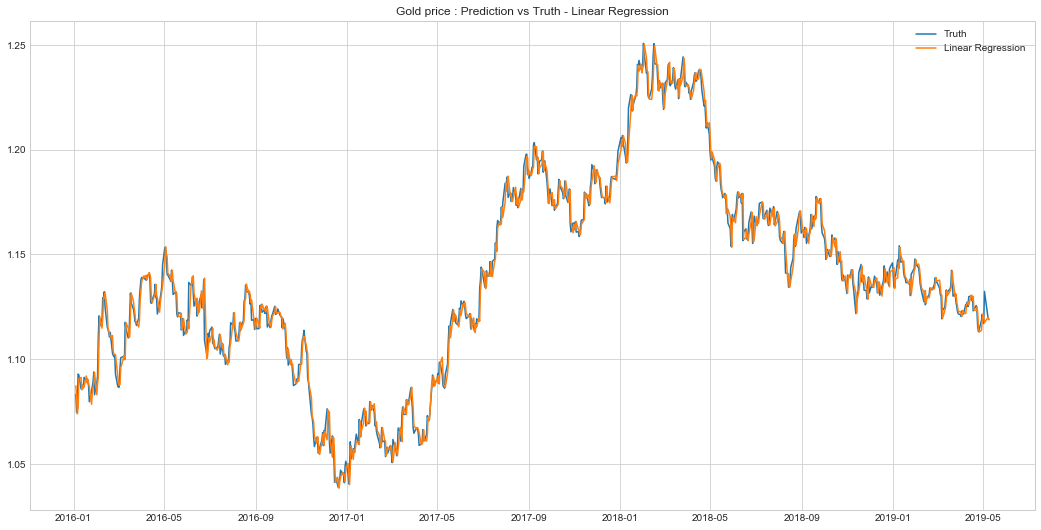

In [60]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

In [62]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))

{'max_depth': 50, 'min_samples_split': 20}
RMSE: 0.006
MAE: 0.005
R^2: 0.984


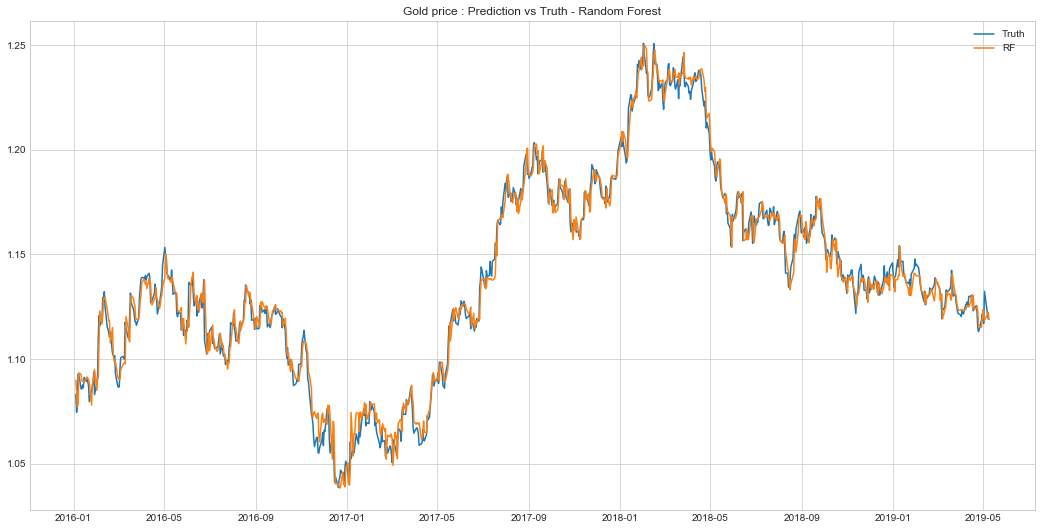

In [63]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()